In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

## Reading Data

In [2]:
data = pd.read_csv("C:\\Users\\shneo\\OneDrive\\exc_phyton\\matala2_cosmetics_2019-Nov_new.csv")
data.head(2)
data = data[:1000000]

C:\Users\shneo\AppData\Local\Temp\ipykernel_13592\1520503455.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:\\Users\\shneo\\OneDrive\\exc_phyton\\matala2_cosmetics_2019-Nov_new.csv")


### Q1

In [3]:
data['event_time'] = pd.to_datetime(data.event_time)

In [4]:
# sort the data by ID and to_datetime
data = data.sort_values(['event_time'])

# compute the time difference between consecutive visits for each ID
data['duration_to_next_event'] = data.groupby('user_session')['event_time'].diff()
data['duration_to_next_event'] = data['duration_to_next_event'].fillna(pd.Timedelta(seconds=0))

In [5]:
data.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event
0,2019-11-01 00:00:02+00:00,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241,0 days
1,2019-11-01 00:00:09+00:00,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,0 days


## Q2

In [6]:
import pandas as pd


# set funnel_number to 1 for the first visit of each user
data['funnel_number'] = 1
data.loc[data.groupby('user_id').head(1).index, 'funnel_number'] = 1

# set funnel_number based on 5-day breaks between visits
data['funnel_number'] = data.groupby('user_id')['duration_to_next_event'].apply(lambda x: (x >= pd.Timedelta(days=5)).cumsum() + 1)

C:\Users\shneo\AppData\Local\Temp\ipykernel_13592\3719360307.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data['funnel_number'] = data.groupby('user_id')['duration_to_next_event'].apply(lambda x: (x >= pd.Timedelta(days=5)).cumsum() + 1)


In [7]:
data[data['funnel_number']==2].head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number
724092,2019-11-06 14:03:28+00:00,view,5847872,1487580006317032337,NaN,NaN,7.94,421526217,7d1ec103-217e-48de-8861-ba3d486137e4,5 days 03:59:31,2
724367,2019-11-06 14:05:58+00:00,cart,5847870,1487580006317032337,NaN,NaN,1.9,421526217,7d1ec103-217e-48de-8861-ba3d486137e4,0 days 00:02:30,2
724530,2019-11-06 14:07:30+00:00,cart,5809912,1602943681873052386,NaN,grattol,5.24,421526217,7d1ec103-217e-48de-8861-ba3d486137e4,0 days 00:01:32,2


In [8]:
data[data ["funnel_number"] == max(data.funnel_number)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number
992576,2019-11-08 05:16:16+00:00,view,5684914,1487580013841613016,NaN,estel,5.79,490982149,a87edd4a-d5f4-456d-ba1a-06e083193e9a,6 days 07:10:47,4


## Q3

In [24]:
# initialize index_in_funnel to 1 for all rows
data['index_in_funnel'] = 1

# set index_in_funnel to the visit number for each user and funnel
data['index_in_funnel'] = data.sort_values(['user_id', 'event_time']).groupby(['user_session', 'funnel_number'])['index_in_funnel'].cumsum()

## Q4

In [11]:
import re

def fix_price(input_price, pattern='\d+\.?\d*'):
    try:
        input_price = float(input_price)
    except:
        try:
            match = re.search(pattern, input_price)
            return float(match.group())
        except:
            return None
    return float(input_price)

In [28]:
data['price'] = data['price'].apply(fix_price)


## Q5

In [13]:
data.groupby('event_type')[["event_type"]].count()

,event_type
event_type,
cart,282941
purchase,66479
remove_from_cart,203126
view,447454


<Axes: xlabel='event_type', ylabel='count'>

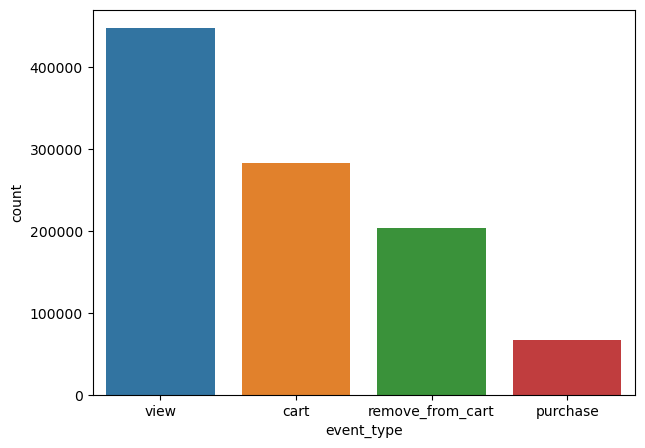

In [14]:
plt.figure(figsize=(7,5)) 
sns.countplot(x="event_type", data=data)

## Q6

In [39]:
sd = data[["user_id","user_session","funnel_number","index_in_funnel","event_type","duration_to_next_event","product_id"]].copy()
sd["num_of_events"] = sd.groupby("user_session")[["event_type"]].transform('count')
sd["duration_per_session"] = sd.groupby(['funnel_number', 'user_session'])[["duration_to_next_event"]].transform('sum')
sd.head()

,user_id,user_session,funnel_number,index_in_funnel,event_type,duration_to_next_event,product_id,num_of_events,duration_per_session
0,562076640,09fafd6c-6c99-46b1-834f-33527f4de241,1,1.0,view,0 days 00:00:00,5802432,8.0,0 days 00:05:00
1,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1,1.0,cart,0 days 00:00:00,5844397,12.0,0 days 00:02:58
2,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f,1,1.0,view,0 days 00:00:00,5837166,20.0,0 days 00:24:17
3,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7,1,1.0,cart,0 days 00:00:00,5876812,2.0,0 days 00:01:43
4,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1,2.0,remove_from_cart,0 days 00:00:15,5826182,12.0,0 days 00:02:58


In [40]:
session_data = sd.groupby(['user_id', 'user_session']).apply(
    lambda x: pd.Series({
        'list_of_viewed': list(x.loc[x['event_type'] == 'view', 'product_id']),
        'list_of_carted': list(x.loc[x['event_type'] == 'cart', 'product_id']),
        'list_of_purchased': list(x.loc[x['event_type'] == 'purchase', 'product_id'])
    })
).reset_index()


In [41]:
session_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200780 entries, 0 to 200779
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            200780 non-null  int64 
 1   user_session       200780 non-null  object
 2   list_of_viewed     200780 non-null  object
 3   list_of_carted     200780 non-null  object
 4   list_of_purchased  200780 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.7+ MB


In [42]:
session_data = pd.merge(sd,session_data , how='left', on=['user_id',"user_session"])
session_data = session_data.drop(columns=['event_type', 'duration_to_next_event',"product_id"])

In [ ]:
session_data.head()